In [82]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib

plt.style.use('ggplot')

# 資料載入

In [83]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [84]:
settlementDate_ = pd.read_csv('settlementDate.csv', encoding = 'big5')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/8/31,202208W5,15078
1,2022/8/24,202208W4,15097
2,2022/8/17,202208,15452
3,2022/8/10,202208W2,14945
4,2022/8/3,202208W1,14707
...,...,...,...
512,2009/12/16,200912,7752
513,2009/11/18,200911,7786
514,2009/10/21,200910,7705
515,2009/9/16,200909,7445


In [85]:
ftr = pd.read_csv('foi&pc_ratio.csv')
ftr.index = pd.to_datetime(ftr.Date)
ftr = ftr.drop(columns = ['Date'])
ftr

,外資未平倉,PC ratio
Date,,
2007-07-02,-6558,94.00
2007-07-03,-7244,99.37
2007-07-04,-10093,107.74
2007-07-05,-11282,112.52
2007-07-06,-11925,115.57
...,...,...
2022-06-06,8528,105.68
2022-06-07,6617,99.09
2022-06-08,9587,107.31


# 資料處裡

日k整理

In [86]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [87]:
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [88]:
Morning=Morning.drop(columns=['Hour'])
daily = Morning.resample("B").agg(dict(zip(Morning.columns,["first", "max", "min", "last", "sum"])))
daily = daily[daily["close"].isna()==False].copy()
daily

,open,high,low,close,volume
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382
...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478


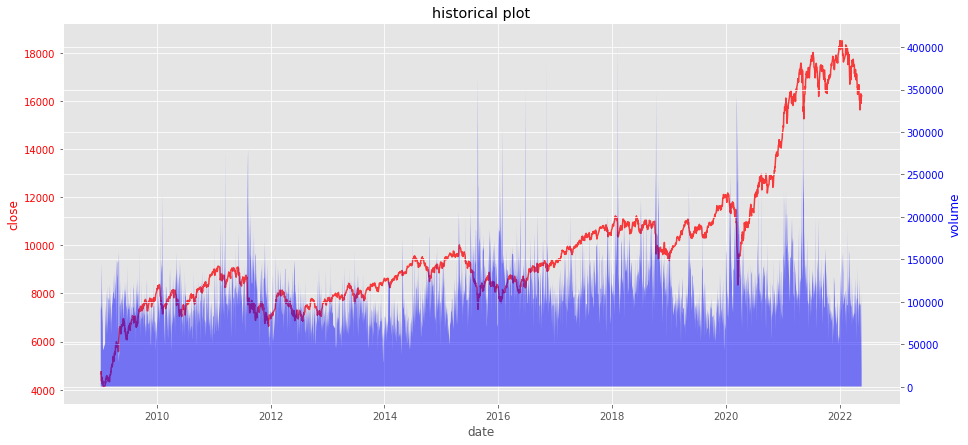

In [107]:
fig, ax1 = plt.subplots(figsize = (15,7))
plt.title('historical plot')
plt.xlabel('date')
ax2 = ax1.twinx()
ax1.set_ylabel('close', color='red')
ax1.plot(daily.close, color='red', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('volume', color='blue')
ax2.fill_between(daily.index, daily.volume, 100, facecolor  = 'blue', label = 'volume', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')

In [9]:
daily = pd.concat([daily, ftr], axis = 1, join = 'inner').dropna()
daily = daily.rename(columns = dict(zip(daily.columns, ['Open', 'High', 'Low', 'Close', 'Volume','Foreign_OI','PC_ratio']))) 
daily

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869,11435,66.79
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227,12294,68.42
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777,14821,70.11
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219,15009,64.57
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382,18302,64.13
...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


切分訓練集和測試集

In [32]:
trainData = daily[(daily.index >= '2011-01-01 00:00:00') & (daily.index <= '2019-12-31 00:00:00')].copy()
testData = daily[(daily.index >= '2020-1-1 00:00:00') & (daily.index <= '2022-5-22 00:00:00')].copy()

In [19]:
trainData.head(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53


In [20]:
testData.tail(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


結算日

In [21]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

# 回測

<p>進場多單條件: mfi指標和收盤價創10天新高，且賣買權未平倉比率put call ratio大於110，隔天以開盤價進場做多<br>
    進場空單條件: mfi指標和收盤價創10天新低，且賣買權未平倉比率put call ratio小於90，隔天以開盤價進場做空<br>
    多單出場條件: 收盤價創10天新高但mfi指標創新低呈現背離，或mfi指標高於80，隔天以開盤價空單出場<br>
    空單出場條件: 收盤價創10天新低但mfi指標創新高呈現背離，或mfi指標低於20，隔天以開盤價多單出場<br>
    停利停損邏輯: 停損2%，停利4%<br>
    結算日不進場，若有部位強制出場

In [14]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
pc_h = 110
pc_l = 90

In [42]:
trainData['mfi'] = talib.MFI(trainData['High'], trainData['Low'], trainData['Close'], trainData['Volume'], timeperiod=14)
trainData['c_max'] = trainData['Close'].rolling(10).max()
trainData['mfi_max'] = trainData['mfi'].rolling(10).max()
trainData['c_min'] = trainData['Close'].rolling(10).min()
trainData['mfi_min'] = trainData['mfi'].rolling(10).min()

In [ ]:
trainData.tail(10)

In [45]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

              profit  profitfee
2011-01-03       0.0        0.0
2011-01-04       0.0        0.0
2011-01-05       0.0        0.0
2011-01-06       0.0        0.0
2011-01-07       0.0        0.0
...              ...        ...
2019-12-25  872000.0   765200.0
2019-12-26  872000.0   765200.0
2019-12-27  872000.0   765200.0
2019-12-30  872000.0   765200.0
2019-12-31  872000.0   765200.0

[2197 rows x 2 columns]


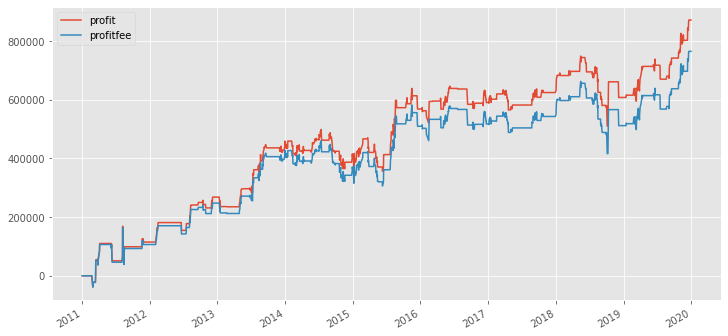

In [55]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] == df_arr[i,9]) & (df_arr[i,3] == df_arr[i,8]) & (df_arr[i,6] >= pc_h)
    entrySellShort = (df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,10]) & (df_arr[i,6] <= pc_l)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,8])) or (df_arr[i,7]>=80)
    exitBuyToCover = ((df_arr[i,7] == df_arr[i,9]) & (df_arr[i,4] == df_arr[i,10])) or (df_arr[i,7]<=20)
    exitCondition = date_arr[i] in settlementDate
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [56]:
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[53, 101, 263, 269, 357, 388, 395, 419, 471, 500, 521, 565, 574, 611, 652, 714, 733, 767, 793, 825, 828, 855, 892, 941, 979, 1000, 1030, 1053, 1170, 1247, 1264, 1292, 1317, 1326, 1328, 1353, 1390, 1407, 1446, 1468, 1491, 1513, 1541, 1621, 1653, 1659, 1709, 1723, 1725, 1752, 1790, 1811, 1837, 1844, 1870, 1890, 1936, 1963, 1985, 2003, 2056, 2081, 2105, 2115, 2147, 2183]
[59, 104, 268, 273, 358, 393, 396, 422, 476, 504, 522, 573, 575, 620, 665, 727, 746, 784, 801, 827, 846, 866, 908, 953, 996, 1014, 1036, 1067, 1176, 1253, 1265, 1295, 1325, 1327, 1329, 1354, 1392, 1415, 1460, 1479, 1493, 1534, 1549, 1641, 1658, 1661, 1716, 1724, 1726, 1760, 1796, 1817, 1840, 1860, 1877, 1895, 1938, 1966, 2002, 2018, 2063, 2083, 2107, 2124, 2168, 2188]
[32, 44, 143, 217, 222, 375, 437, 448, 604, 635, 755, 915, 930, 1068, 1085, 1112, 1122, 1137, 1190, 1213, 1231, 1303, 1897]
[35, 46, 152, 218, 223, 378, 441, 449, 606, 646, 760, 917, 937, 1069, 1091, 1117, 1134, 1138, 1196, 1216, 1234, 1314, 1899]


In [57]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

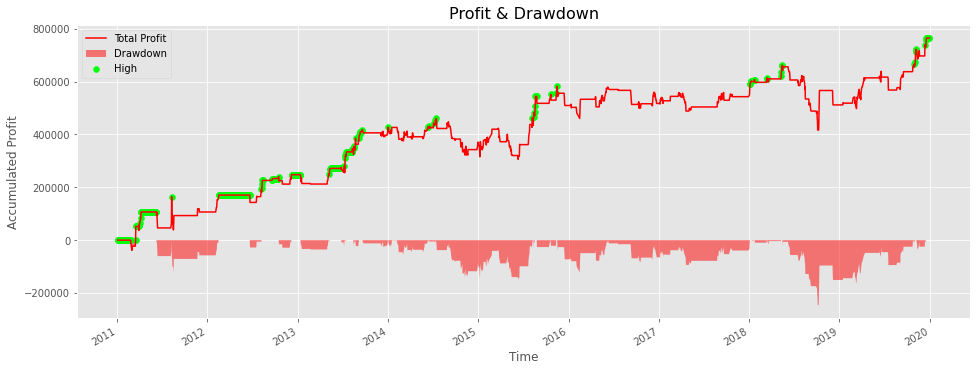

In [58]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

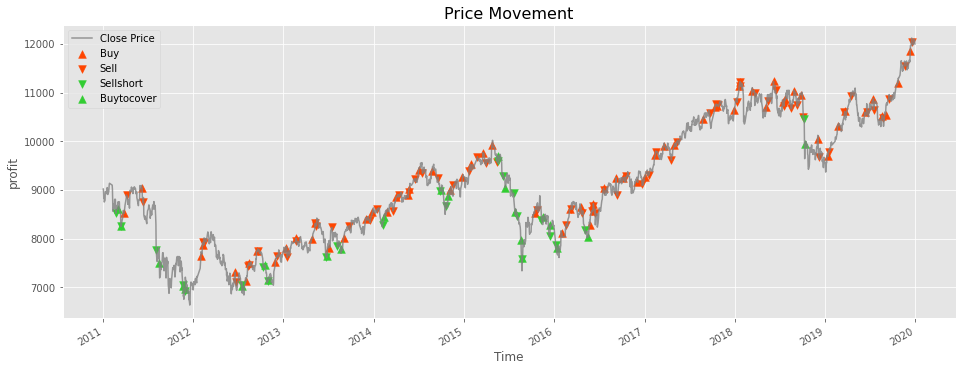

In [59]:
fig, ax = plt.subplots(figsize = (16,6))

trainData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['Close'].iloc[buy].index, trainData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['Close'].iloc[sell].index, trainData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[sellshort].index, trainData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[buytocover].index, trainData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [60]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $765200.0
return: 76.52%
mdd: 14.790000000000001%
calmarRatio: 5.17
tradeTimes: 89
winRate: 57.3%
profitFactor: 1.75
winLossRatio: 1.27


# 最佳化

對mfi指標窗口、mfi與收盤價回看天數、賣買權未平倉比上下界做最佳化

In [61]:
optimizationList = []

fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
rule = '1D'

for f in range(7,15,1):
    for s in range(5, 11, 1):
        for h in range(105,140,5):
            for l in range(65,100,5):
                print('----------')
                print(f'mfi_window: {f}')
                print(f'回顧日期: {s}')
                print(f'pc_ratio high: {h}')
                print(f'pc_ratio low: {l}')
                data = trainData.iloc[:,:7].copy()
                
                data['mfi'] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=f)
                data['c_max'] = data['Close'].rolling(window=s).max()
                data['mfi_max'] = data['mfi'].rolling(window=s).max()
                data['c_min'] = data['Close'].rolling(window=s).min()
                data['mfi_min'] = data['mfi'].rolling(window=s).min()

                time_arr = np.array(data.index)
                df_arr = np.array(data)
        

                BS = None
                buy = []
                sell = []
                sellshort = []
                buytocover = []
                profit_list = [0]
                profit_fee_list = [0]
                profit_fee_list_realized = []

                for i in range(len(df_arr)):
                    if i == len(df_arr)-1:
                        break
        
                ## 進場邏輯
                    entryLong = (df_arr[i,7] == df_arr[i,9]) & (df_arr[i,3] == df_arr[i,8]) & (df_arr[i,6] >= h)
                    entrySellShort = (df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,10]) & (df_arr[i,6] <= l)
                    entryCondition = date_arr[i] not in settlementDate
    
                ## 出場邏輯
                    exitShort = ((df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,8])) or (df_arr[i,7]>=80)
                    exitBuyToCover = ((df_arr[i,7] == df_arr[i,9]) & (df_arr[i,4] == df_arr[i,10])) or (df_arr[i,7]<=20)
                    exitCondition = date_arr[i] in settlementDate
    
                ## 停利停損邏輯
                    if BS == 'B':
                        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
                        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                    elif BS == 'S':
                        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
                        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

                    if BS == None:
                        profit_list.append(0)
                        profit_fee_list.append(0)
         
                        if entryLong and entryCondition:
                            BS = 'B'
                            t = i+1
                            buy.append(t)

                        elif entrySellShort and entryCondition:
                            BS = 'S'
                            t = i+1
                            sellshort.append(t)
            
                    elif BS == 'B':
                        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
                        profit_list.append(profit)
            
                        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            sell.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
             
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
            
                    elif BS == 'S': 
                        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
                        profit_list.append(profit)
        
                        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
                            profit_fee = profit - feePaid*2
                            profit_fee_list.append(profit_fee)
                            buytocover.append(i+1)
                            BS=None
            
                            # Realized PnL
                            profit_fee_realized = pl_round - feePaid*2
                            profit_fee_list_realized.append(profit_fee_realized)
 
                        else:
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
     
                equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=data.index)
                equity['equity'] = equity['profitfee'] + fund
                equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
                equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
                ret = equity['equity'][-1]/equity['equity'][0] - 1
                mdd = abs(equity['drawdown_percent'].min())
                calmarRatio = ret / mdd
                   
                optimizationList.append([f, s, h, l, ret, calmarRatio])###

----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window: 7
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 5
p

----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 7
pc_ratio high: 130
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 7
p

----------
mfi_window: 7
回顧日期: 9
pc_ratio high: 135
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 7
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window

----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 8
回顧日期: 6
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 8
回顧日期: 6
p

----------
mfi_window: 8
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 75
----------
mfi_window: 8
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 80
----------
mfi_window: 8
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 85
----------
mfi_window: 8
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 90
----------
mfi_window: 8
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 95
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 8
回顧日期: 9
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 8
回顧日期: 9
p

----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 5
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 5
p

----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 8
p

----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 130
pc_ratio low: 75
----------
mfi_window: 9
回顧日期: 10
pc_ratio high: 130
pc_ratio low: 80
----------
mfi_windo

----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 110
pc_ratio low: 95
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 115
pc_ratio low: 65
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 115
pc_ratio low: 70
----------
mfi_window: 10
回顧日期: 7
pc_ratio high: 115
pc_ratio low: 75
----------
mfi_windo

----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 130
pc_ratio low: 75
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 130
pc_ratio low: 80
----------
mfi_window: 10
回顧日期: 9
pc_ratio high: 130
pc_ratio low: 85
----------
mfi_windo

----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 110
pc_ratio low: 95
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 115
pc_ratio low: 65
----------
mfi_window: 11
回顧日期: 6
pc_ratio high: 115
pc_ratio low: 70
----------
mfi_windo

----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 70
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 75
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 80
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 85
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 90
----------
mfi_window: 11
回顧日期: 8
pc_ratio high: 130
pc_ratio low: 95
----------
mfi_windo

----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 90
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 110
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 5
pc_ratio high: 115
pc_ratio low: 65
----------
mfi_windo

----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 7
pc_ratio high: 130
pc_ratio low: 65
----------
mfi_windo

----------
mfi_window: 12
回顧日期: 9
pc_ratio high: 135
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 75
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 80
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 85
----------
mfi_window: 12
回顧日期: 10
pc_ratio high: 110
pc_ratio low: 90
-------

----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 65
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 70
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 13
回顧日期: 6
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_windo

----------
mfi_window: 13
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 75
----------
mfi_window: 13
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 80
----------
mfi_window: 13
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 85
----------
mfi_window: 13
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 90
----------
mfi_window: 13
回顧日期: 8
pc_ratio high: 135
pc_ratio low: 95
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 13
回顧日期: 9
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_windo

----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 70
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 85
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 5
pc_ratio high: 125
pc_ratio low: 95
----------
mfi_windo

----------
mfi_window: 14
回顧日期: 7
pc_ratio high: 135
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 7
pc_ratio high: 135
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 7
pc_ratio high: 135
pc_ratio low: 85
----------
mfi_window: 14
回顧日期: 7
pc_ratio high: 135
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 7
pc_ratio high: 135
pc_ratio low: 95
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 70
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 85
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 105
pc_ratio low: 95
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 8
pc_ratio high: 110
pc_ratio low: 70
----------
mfi_windo

----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 115
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 115
pc_ratio low: 95
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 70
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 85
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 90
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 120
pc_ratio low: 95
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 65
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 70
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 75
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 80
----------
mfi_window: 14
回顧日期: 10
pc_ratio high: 125
pc_ratio low: 85
------

In [62]:
len(optimizationList)

2352

In [63]:
optimizationList = pd.DataFrame(optimizationList, columns=['mfi_window','lookback', 'high','low','ret','calmarRatio'])
optimizationList

,mfi_window,lookback,high,low,ret,calmarRatio
0,7,5,105,65,-0.2388,-0.522835
1,7,5,105,70,-0.1382,-0.327015
2,7,5,105,75,-0.2312,-0.510203
3,7,5,105,80,-0.2612,-0.585370
4,7,5,105,85,-0.3686,-0.668360
...,...,...,...,...,...,...
2347,14,10,135,75,0.5740,5.269283
2348,14,10,135,80,0.5606,5.146272
2349,14,10,135,85,0.6698,6.360967
2350,14,10,135,90,0.6422,5.517466


In [64]:
optimizationList.sort_values('ret', ascending=False).iloc[:5]

,mfi_window,lookback,high,low,ret,calmarRatio
1817,13,6,105,85,0.8882,5.796565
1818,13,6,105,90,0.8766,5.296246
1965,13,9,105,90,0.8212,6.045370
2314,14,10,110,85,0.8136,5.659481
2307,14,10,105,85,0.8076,5.687999


In [65]:
optimizationList.sort_values('calmarRatio', ascending=False).iloc[:5]

,mfi_window,lookback,high,low,ret,calmarRatio
1608,12,7,130,90,0.7604,8.009113
1993,13,9,125,90,0.8062,7.498430
2007,13,9,135,90,0.8006,7.358381
1615,12,7,135,90,0.7534,7.108207
1992,13,9,125,85,0.7418,7.034107


In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\User\AppData\Local\Temp\ipykernel_6244\2088067881.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


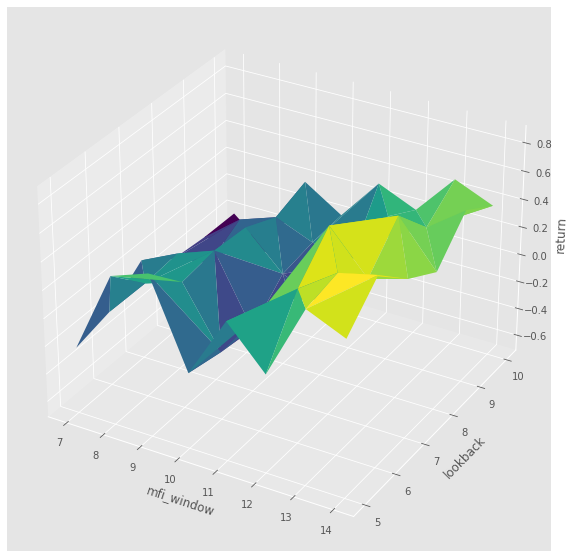

In [68]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.mfi_window, optimizationList.lookback, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('mfi_window')
ax.set_ylabel('lookback')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6244\2934912639.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


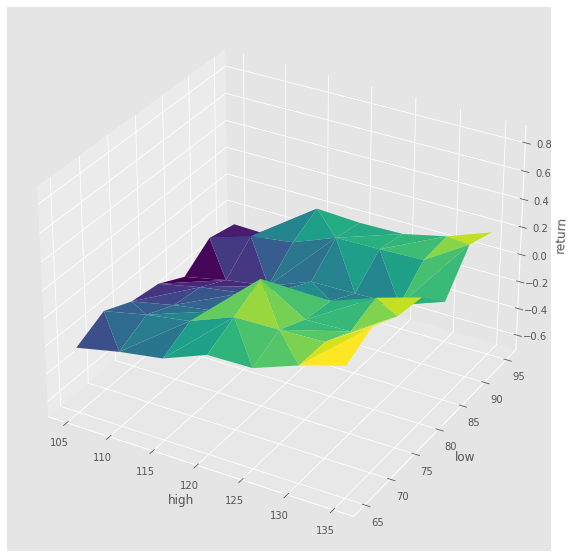

In [69]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.ret, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6244\580683519.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


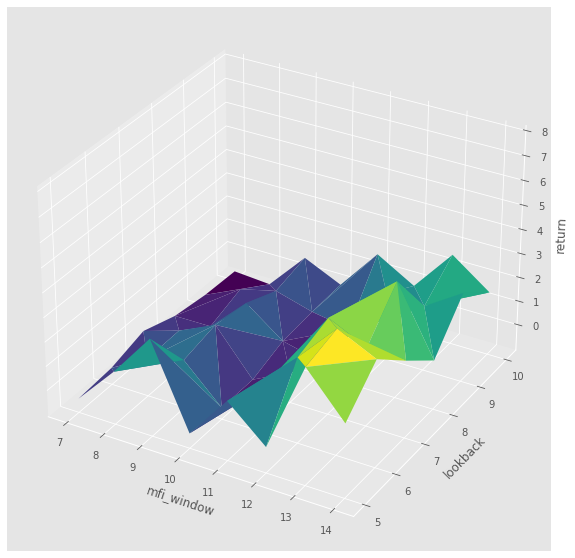

In [70]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.mfi_window, optimizationList.lookback, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('mfi_window')
ax.set_ylabel('lookback')
ax.set_zlabel('return')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_6244\2961654477.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


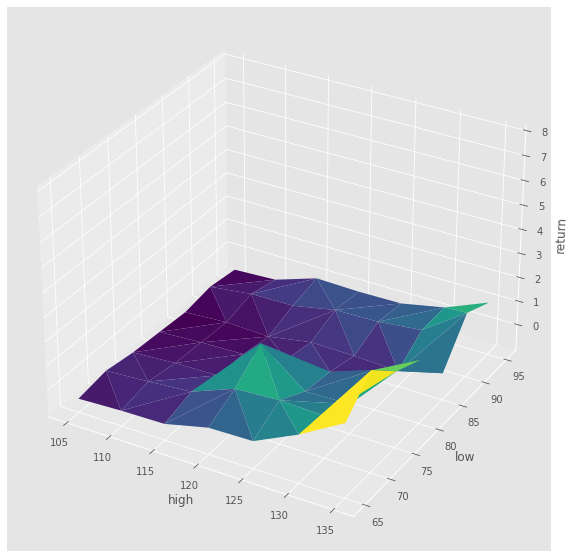

In [71]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(optimizationList.high, optimizationList.low, optimizationList.calmarRatio, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('high')
ax.set_ylabel('low')
ax.set_zlabel('return')
plt.show()

# 樣本外測試

In [72]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02
testData['mfi'] = talib.MFI(testData['High'], testData['Low'], testData['Close'], testData['Volume'], timeperiod=12)
testData['c_max'] = testData['Close'].rolling(7).max()
testData['mfi_max'] = testData['mfi'].rolling(7).max()
testData['c_min'] = testData['Close'].rolling(7).min()
testData['mfi_min'] = testData['mfi'].rolling(7).min()
df_arr = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

              profit  profitfee
2020-01-02       0.0        0.0
2020-01-03       0.0        0.0
2020-01-06       0.0        0.0
2020-01-07       0.0        0.0
2020-01-08       0.0        0.0
...              ...        ...
2022-05-16  600200.0   555800.0
2022-05-17  600200.0   555800.0
2022-05-18  600200.0   555800.0
2022-05-19  600200.0   555800.0
2022-05-20  600200.0   555800.0

[578 rows x 2 columns]


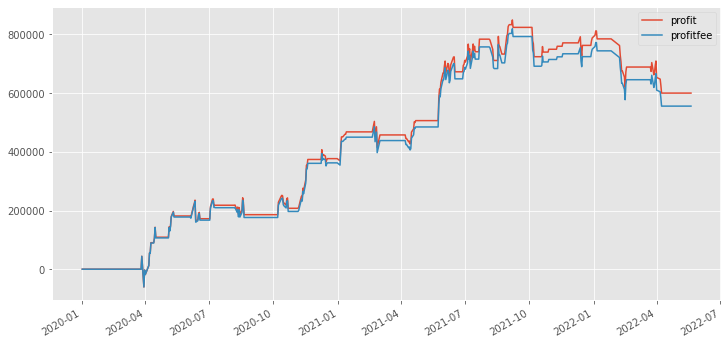

In [74]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = (df_arr[i,7] == df_arr[i,9]) & (df_arr[i,3] == df_arr[i,8]) & (df_arr[i,6] >= 105)
    entrySellShort = (df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,10]) & (df_arr[i,6] <= 85)
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,7] == df_arr[i,11]) & (df_arr[i,3] == df_arr[i,8])) or (df_arr[i,7]>=80)
    exitBuyToCover = ((df_arr[i,7] == df_arr[i,9]) & (df_arr[i,4] == df_arr[i,10])) or (df_arr[i,7]<=20)
    exitCondition = date_arr[i] in settlementDate  ####
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [75]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

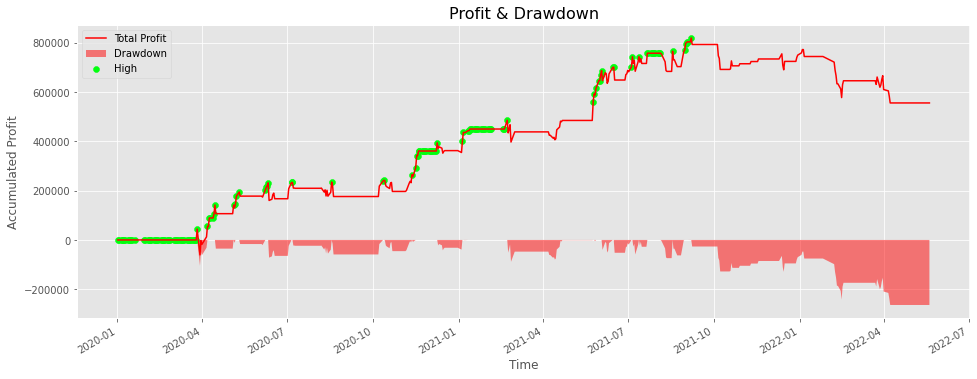

In [76]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

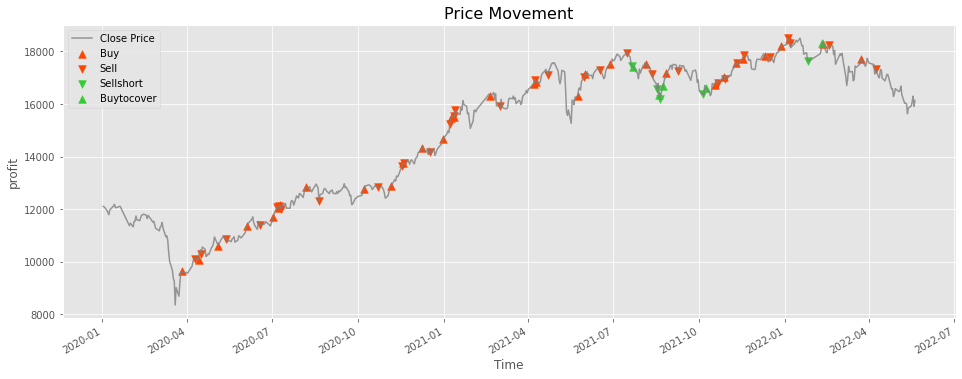

In [77]:
fig, ax = plt.subplots(figsize = (16,6))

testData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(testData['Close'].iloc[buy].index, testData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(testData['Close'].iloc[sell].index, testData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(testData['Close'].iloc[sellshort].index, testData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(testData['Close'].iloc[buytocover].index, testData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [78]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $555800.0
return: 55.58%
mdd: 14.499999999999998%
calmarRatio: 3.83
tradeTimes: 37
winRate: 64.86%
profitFactor: 2.04
winLossRatio: 1.11
